# Working Simulation Code so far

In [23]:
import meep as mp
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# Simulation parameters
# -----------------------------
resolution = 10  # pixels/um

# Materials
gaas = mp.Medium(epsilon=11.3569) 
air = mp.Medium(epsilon=1)

# Disk and waveguide geometry
disk_radius = 5
wg_length = 20
wg_width = 0.3
gap = 0.232  # distance between disk and waveguides

# Simulation cell size
cell_x = wg_length + 10
cell_y = 2*(disk_radius + gap + wg_width/2) + 10
cell = mp.Vector3(cell_x, cell_y, 0)

# PML layers
pml_layers = [mp.PML(2.0)]

# -----------------------------
# Geometry: disk + two waveguides
# -----------------------------
geometry = [
    mp.Cylinder(radius=disk_radius, height=mp.inf, center=mp.Vector3(0,0), material=gaas),
    mp.Block(size=mp.Vector3(wg_length, wg_width, mp.inf),
             center=mp.Vector3(0, disk_radius + gap + wg_width/2),
             material=gaas),
    mp.Block(size=mp.Vector3(wg_length, wg_width, mp.inf),
             center=mp.Vector3(0, -disk_radius - gap - wg_width/2),
             material=gaas)
]


In [17]:

# -----------------------------
# Source (broadband run)
# -----------------------------
source_x = -wg_length/2
source_y = disk_radius + gap + wg_width/2

#fmin = 0.3
#fmax = 0.35
#df = fmax - fmin

f_cen = 0.645
df = 0.02

nfreq = 500
resolution = 20  # pixels/um

sources = [mp.Source(mp.GaussianSource(frequency=f_cen, fwidth=df),
                     component=mp.Ez,
                     center=mp.Vector3(source_x, source_y),
                     size=mp.Vector3(0, wg_width, 0))]

# -----------------------------
# Flux monitors
# -----------------------------
flux_region_bus = mp.FluxRegion(center=mp.Vector3(wg_length/2 - 1,
                                                  disk_radius + gap + wg_width/2),
                                size=mp.Vector3(0, wg_width, 0))

# Drop port moved to left side of lower waveguide (same side as source, opposite waveguide)
flux_region_drop = mp.FluxRegion(center=mp.Vector3(-wg_length/2 + 1,
                                                   -disk_radius - gap - wg_width/2),
                                 size=mp.Vector3(0, wg_width, 0))

# -----------------------------
# First Simulation (spectra)
# -----------------------------
sim = mp.Simulation(cell_size=cell,
                    geometry=geometry,
                    sources=sources,
                    boundary_layers=pml_layers,
                    resolution=resolution)

trans_flux_bus = sim.add_flux(f_cen, df, nfreq, flux_region_bus)
trans_flux_drop = sim.add_flux(f_cen, df, nfreq, flux_region_drop)

sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, mp.Vector3(), 5e-3))


frequencies = np.array(mp.get_flux_freqs(trans_flux_bus))
flux_bus = np.array(mp.get_fluxes(trans_flux_bus))
flux_drop = np.array(mp.get_fluxes(trans_flux_drop))

# -----------------------------
# Find resonance from max |flux_drop|
# -----------------------------
res_freq = frequencies[np.argmax(np.abs(flux_drop))]
print(f"Resonance frequency (max |drop port|): {res_freq:.6f} 1/um")

## Conversion: Meep freq (1/um) → THz
c0 = 299792458  # m/s
um_scale = 1e-6  # 1 µm in m
freq_thz = frequencies * c0 / um_scale / 1e12
res_freq_thz = res_freq * c0 / um_scale / 1e12

# Plot
plt.figure(figsize=(8,5))
plt.plot(freq_thz, flux_bus, label='Bus (top, right)')
plt.plot(freq_thz, flux_drop, label='Drop (bottom, left)')
plt.axvline(res_freq_thz, color='r', ls='--', label=f'Peak (drop) = {res_freq_thz:.2f} THz')
plt.xlabel('Frequency (THz)')
plt.ylabel('Flux')
plt.title('Broadband transmission spectra (Gaussian source)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()



-----------
Initializing structure...
time for choose_chunkdivision = 0.00259709 s
Working in 2D dimensions.
Computational cell is 40 x 20.75 x 0 with resolution 20
     cylinder, center = (0,0,0)
          radius 5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (11.3569,11.3569,11.3569)
     block, center = (0,5.382,0)
          size (30,0.3,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.3569,11.3569,11.3569)
     block, center = (0,-5.382,0)
          size (30,0.3,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.3569,11.3569,11.3569)


time for set_epsilon = 0.951994 s
-----------
on time step 837 (time=20.925), 0.00478183 s/step
on time step 1761 (time=44.025), 0.00432966 s/step
field decay(t = 50.025000000000006): 2.6836271659633512e-14 / 2.6836271659633512e-14 = 1.0


KeyboardInterrupt: 

-----------
Initializing structure...
time for choose_chunkdivision = 0.00067997 s
Working in 2D dimensions.
Computational cell is 30 x 20.7667 x 0 with resolution 30
     cylinder, center = (0,0,0)
          radius 5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (11.3569,11.3569,11.3569)
     block, center = (0,5.382,0)
          size (20,0.3,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.3569,11.3569,11.3569)
     block, center = (0,-5.382,0)
          size (20,0.3,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.3569,11.3569,11.3569)
time for set_epsilon = 1.01347 s
-----------


FloatProgress(value=0.0, description='0% done ', max=800.0)

Meep progress: 8.65/800.0 = 1.1% done in 4.0s, 366.3s to go
on time step 519 (time=8.65), 0.00770781 s/step
Meep progress: 17.516666666666666/800.0 = 2.2% done in 8.0s, 357.8s to go
on time step 1051 (time=17.5167), 0.00752998 s/step
Meep progress: 26.349999999999998/800.0 = 3.3% done in 12.0s, 352.9s to go
on time step 1581 (time=26.35), 0.00755941 s/step
Meep progress: 35.11666666666667/800.0 = 4.4% done in 16.0s, 349.0s to go
on time step 2107 (time=35.1167), 0.0076134 s/step
Meep progress: 44.016666666666666/800.0 = 5.5% done in 20.0s, 344.0s to go
on time step 2641 (time=44.0167), 0.00749718 s/step
Meep progress: 52.93333333333333/800.0 = 6.6% done in 24.0s, 339.2s to go
on time step 3176 (time=52.9333), 0.00748396 s/step
Meep progress: 61.699999999999996/800.0 = 7.7% done in 28.0s, 335.5s to go
on time step 3702 (time=61.7), 0.00760721 s/step
Meep progress: 70.76666666666667/800.0 = 8.8% done in 32.0s, 330.2s to go
on time step 4246 (time=70.7667), 0.00736276 s/step
Meep progress

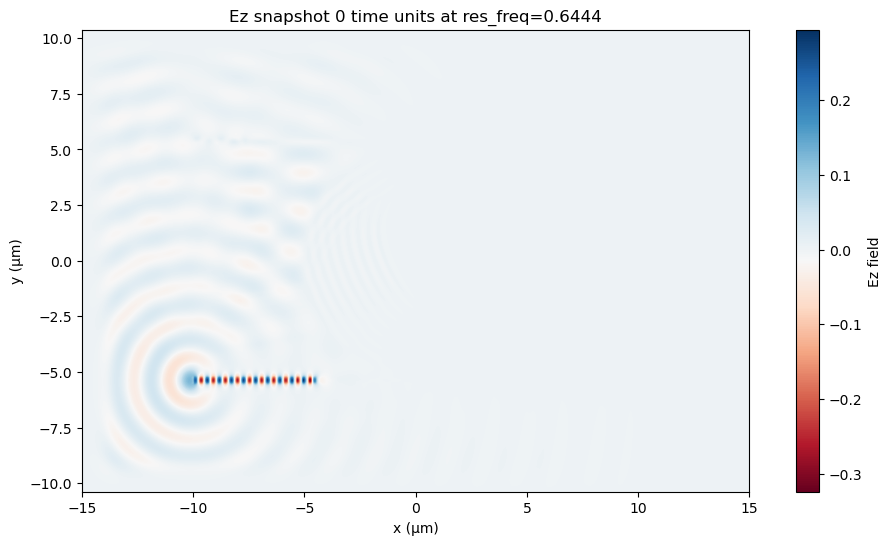

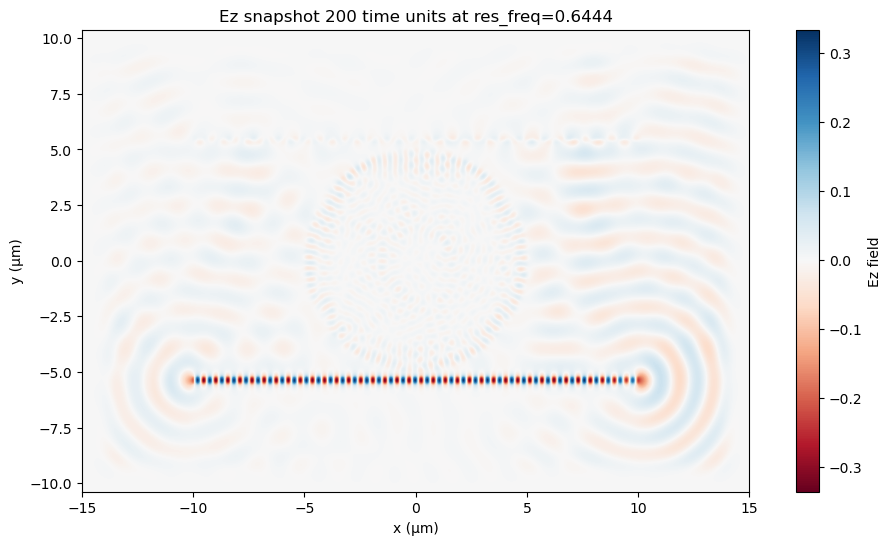

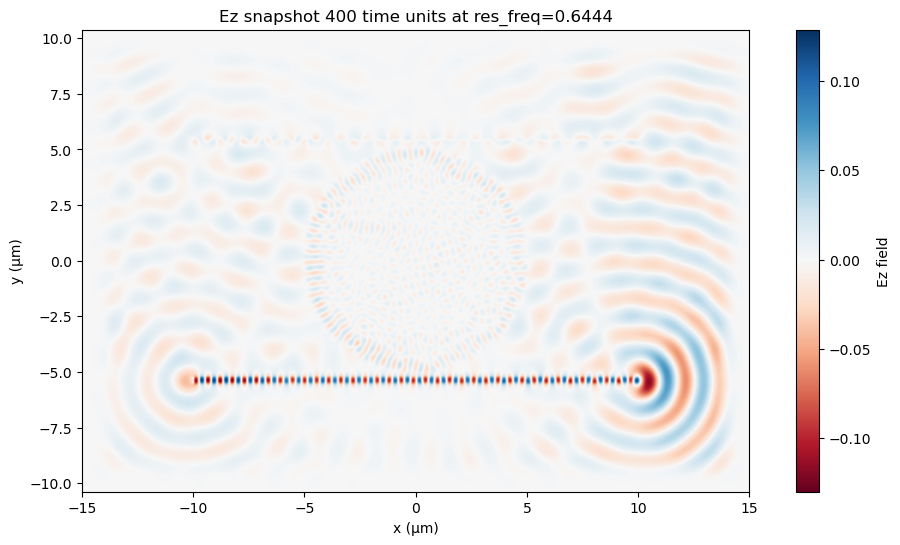

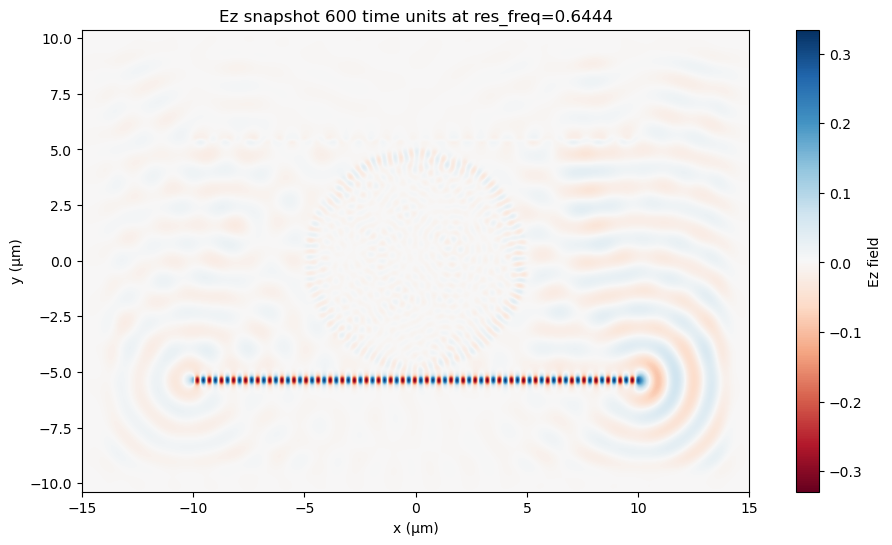

In [26]:
# -----------------------------
# Second Simulation (single freq)
# -----------------------------

# -----------------------------
# Source (broadband run)
# -----------------------------
source_x = -wg_length/2
source_y = disk_radius + gap + wg_width/2


nfreq = 500
resolution = 30  # pixels/um


sources_res = [mp.Source(mp.ContinuousSource(frequency=0.631103),
                         component=mp.Ez,
                         center=mp.Vector3(source_x, source_y),
                         size=mp.Vector3(0, wg_width, 0))]

sim_res = mp.Simulation(cell_size=cell,
                        geometry=geometry,
                        sources=sources_res,
                        boundary_layers=pml_layers,
                        resolution=resolution)

ez_data = []
def store_fields(sim):
    ez_data.append(sim.get_array(center=mp.Vector3(),
                                 size=cell,
                                 component=mp.Ez))

sim_res.run(mp.at_every(20, store_fields), until=800)

# -----------------------------
# Plot Ez snapshots
# -----------------------------
for i, field in enumerate(ez_data):
    if i % 10 == 0:
        plt.figure(figsize=(12,6))
        plt.imshow(np.rot90(field), cmap="RdBu", origin="lower",
                   extent=[-cell_x/2, cell_x/2, -cell_y/2, cell_y/2])
        plt.colorbar(label="Ez field")
        plt.title(f"Ez snapshot {i*20} time units at res_freq={res_freq:.4f}")
        plt.xlabel("x (µm)")
        plt.ylabel("y (µm)")
        plt.show()

In [5]:
# -----------------------------
# Second Simulation (Harminv mode analysis)
# -----------------------------
# We reuse the same geometry & source, but this time only run Harminv
sim_h = mp.Simulation(cell_size=cell,
                      geometry=geometry,
                      sources=sources,
                      boundary_layers=pml_layers,
                      resolution=resolution)

# Add Harminv at disk center (can also try at edge)
harminv = mp.Harminv(mp.Ez, mp.Vector3(disk_radius-0.05,0), (fmin+fmax)/2, df)


sim_h.run(mp.after_sources(harminv), until_after_sources=mp.stop_when_fields_decayed(
    50, mp.Ez, mp.Vector3(0,0), 8e-3))

print("\nHarminv modes found:")
for mode in harminv.modes:
    freq_um = mode.freq
    wl_um = 1/freq_um
    freq_thz = freq_um * c0 / um_scale / 1e12
    print(f"f = {freq_um:.6f} 1/um  ({freq_thz:.2f} THz),  λ = {wl_um:.2f} µm,  Q = {mode.Q:.1f}")

-----------
Initializing structure...
time for choose_chunkdivision = 0.000499964 s
Working in 2D dimensions.
Computational cell is 50 x 17.4 x 0 with resolution 20
     cylinder, center = (0,0,0)
          radius 3.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,3.71,0)
          size (40,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,-3.71,0)
          size (40,0.22,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.568097 s
-----------
on time step 809 (time=20.225), 0.00494509 s/step
on time step 1641 (time=41.025), 0.00480978 s/step
field decay(t = 50.025000000000006): 9.833485561098147e-13 / 9.833485561098147e-13 = 1.0
on time step 2457 (time=61.425), 0.00490295 s/step
on time step 3233 (time=80.825), 0.00515716 s/step
field decay(t = 100.05000